# “数字信号处理”课程设计——工作台

本文件为课程设计项目“语音信号增采样”提供给一个设计、开发和测试的环境。

本文件也属于被评分的部分，学生需要连同课程设计报告一并提交，但请注意以下要求：
- 保留完整的增采样方法的实现代码和输出结果，并进行适当的注释和说明。
- 确保不需要任何改动（例如修改参数），可以全部直接运行和显示结果。
- 删除所有多余的调试代码、无用输出结果等。
- 本文件中可以包含原理说明、结果分析等非编程实现类的内容，但只作为学生自己参考用，教师将仅以课程设计报告中的相关内容作为评分依据。

In [4]:
# Initialization for this notebook.

import numpy as np
from scipy import signal
from scipy import fft
import matplotlib.pyplot as plt

# Import everything from `lib/dsp.py`.
from lib.dsp import *

# Un-comment the following line to use interactive matplotlib widget.
# %matplotlib widget

## 引言

以下的代码通过对一组特定信号的频谱分析，引导学生思考如何通过数字滤波的方法实现增采样。

定义一个信号发生函数，用于生成类似语音信号的信号序列。

In [2]:
def gen_signal(fs, n):
    """Generate a test signal that comsists of several sin components."""
    # Create a list of parameters, (A, w, phi), for each sin component.
    x_comp = []
    x_comp.append((0.30, 2*np.pi/fs * 1.0e3, 0))
    x_comp.append((0.25, 2*np.pi/fs * 1.5e3, 0))
    x_comp.append((0.20, 2*np.pi/fs * 2.0e3, 0))
    x_comp.append((0.15, 2*np.pi/fs * 2.5e3, 0))
    x_comp.append((0.10, 2*np.pi/fs * 3.0e3, 0))
    
    # Generate the sequence by combining all sin components.
    x = np.sum([seq_sin(A, w, phi, 0, n-1) for A, w, phi in x_comp], axis=0)[0]

    return x

画出三个信号及其频谱：
- 低采样率(8KHz)信号 `x`
- 对 `x` 进行样本间“插零”后的信号 `x_insert_0`
- 目标高采样率(8KHz*6=48KHz)信号 `x_target`

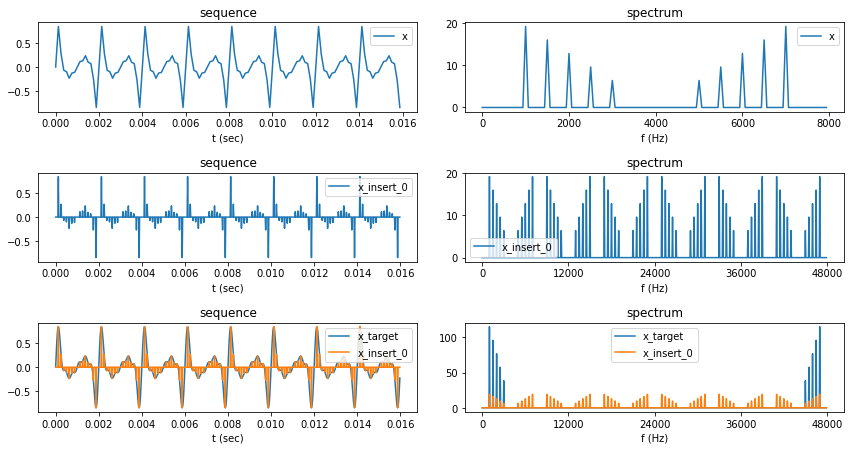

In [3]:
x_len = 128     # length of the low sampling rate signal
fs_x = 8e3      # the low sampling rate
up_factor = 6   # upsampling factor

fs_up = fs_x * up_factor
x_len_up = x_len * up_factor

# Generate the low sampling rate signal.
x = gen_signal(fs_x, x_len)

# Insert zeros between samples.
x_insert_0 = np.zeros(x_len_up)
x_insert_0[::up_factor] = x

# Generate a high sampling rate target signal.
x_target = gen_signal(fs_up, x_len_up)

# Plot the signals for inspection.
fig, axs = plt.subplots(3, 2, figsize=(12,6))
fig.tight_layout(h_pad=4)
TITLES = ['sequence', 'spectrum']
plot_signals(['x'], [x], fs_x, axs[0,:], TITLES)
plot_signals(['x_insert_0'], [x_insert_0], fs_up, axs[1,:], TITLES)
plot_signals(
    ['x_target', 'x_insert_0'],
    [x_target, x_insert_0],
    fs_up, axs[2,:],
    TITLES
)

## 基于数字滤波的增采样方法设计

基于以上信号的特点，设计一个基于数字滤波器的增采样方法。

【提示】将低采样率的信号 `x` 通过插零得到 `x_insert_0`，再输入某个数字滤波器后，得到接近目标高采样率信号 `x_target` 的信号 `x_filter`。

请按以下指引，在下文编写程序实现该方法：
- 制定数字滤波器的技术指标。
- 计算满足指标的数字滤波器的系数 `b` 和 `a`。
- 编写一个函数`upsample_filter()`，输入低采样率的信号 `x`，输出通过滤波方法得到的增采样信号 `x_filter`
- 将信号 `x_filter` 与 `x_target` 对齐画在同一个坐标系中进行比较。
  - `x_filter` 相对于 `x_target` 是有延迟，且需要经过一段时间才能达到稳定。因此，需要进行一定的处理才可得到有意义的比较。【提示】截取“有效”部分并对齐。
  通过平移来尽量对齐重叠。
- 计算 `x_filter` 与 `x_target` 有效对齐部分的 MSE（均方差）。
- 尝试不同的滤波器类型和参数，找到最优方案，即 MSE 最小的滤波器及其参数。
  - 至少尝试一种IIR和一种FIR滤波器

## 基于时域插值的增采样方法

查阅资料，学习最近邻域插值(nearest neighbour interpolation)、线性插值(linear interpolation)的基本原理。

【提示】可以利用现成的函数库进行插值计算。

请按以下指引，在下文编写程序实现该方法：
- 编写一个函数 `upsample_interp()`，输入低采样率的信号 `x`，输出通过插值方法得到的增采样信号 `x_interp`。
- 将信号 `x_interp` 与 `x_target` 对齐画在同一个坐标系中进行比较。
  - 注意 `x_interp` 相对于 `x_target` 是否有延迟，是否需要截取“有效”部分并对齐。
- 计算 `x_interp` 与 `x_target` 有效对齐部分的 MSE（均方差）。
- 尝试不同插值类型，找到最优方案，即 MSE 最小插值类型出。